## Importación de las librerías

In [1]:
import utils
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

## Conjuntos de entrenamiento y test y CV controller

In [2]:
X_train, X_test, y_train, y_test = utils.get_train_test_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7776, 12) (1022, 12) (7776,) (1022,)


In [3]:
cv = utils.get_stratified_shuffle_cv()
print(cv)

StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8)


## Búsqueda de los hiperparámetros del árbol de clasificación

In [8]:
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': list(range(5,101,5)),
    'min_samples_leaf': list(range(5,101,5)),
    'min_samples_split': list(range(5,101,5))
}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=99),
                              param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=DecisionTreeClassifier(random_state=99), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                       55, 60, 65, 70, 75, 80, 85, 90, 95,
                                       100],
                         'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100],
                         'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40,
                                               45, 50, 55, 60, 65, 70, 75, 80,
                                               85, 90, 95, 100]},
             scoring='roc_auc')

In [14]:
criterion_list = list(grid_search_cv.cv_results_['param_criterion'].data)
max_depth_list = list(grid_search_cv.cv_results_['param_max_depth'].data)
min_samples_leaf_list = list(grid_search_cv.cv_results_['param_min_samples_leaf'].data)
min_samples_split_list = list(grid_search_cv.cv_results_['param_min_samples_split'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])

decision_tree_df = pd.DataFrame(list(zip(criterion_list, max_depth_list, min_samples_leaf_list, min_samples_split_list, mean_test_score_list)),
                                columns=['criterion', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'mean_test_score'])

Mirando un poco a ojo se puede intentar obtener un arbol de no mucha complejidad para pasos futuros:
- **criterio**: **gini**
- **max_depth**: se escoge **10**, es un arbol más sencillo, con menos profundidad y apartir de alli la mejora no es tan significativa
    - 5-10: aumenta de 90% a 93%
    - 10-15: aumenta de 93% a 94%
    - 15-20: aumenta de 94% a 94,5%
- **min_samples_leaf**: se escoge **45**, es un arbol más sencillo, con más observaciones por hoja y apartir de alli el árbol empeora de manera significativa
    - 5-45: disminuye de 96% a 95% (aprox)
- **min_samples_split**: se escoge **200**, es un arbol más sencillo, con menos observaciones requeridas para hacer el split de un nodo

<AxesSubplot:xlabel='min_samples_split', ylabel='mean_test_score'>

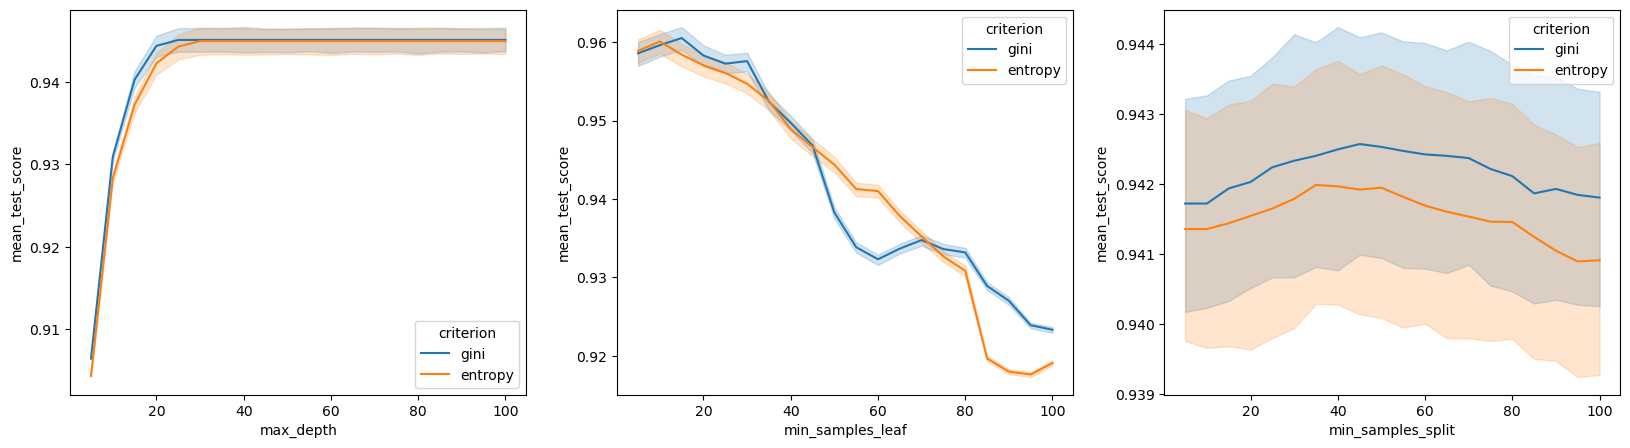

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
sns.lineplot(data=decision_tree_df, x="max_depth", y="mean_test_score", hue="criterion", ax=axes[0])
sns.lineplot(data=decision_tree_df, x="min_samples_leaf", y="mean_test_score", hue="criterion", ax=axes[1])
sns.lineplot(data=decision_tree_df, x="min_samples_split", y="mean_test_score", hue="criterion", ax=axes[2])

**Modelo de árbol de clasificación**

Confusion matrix, without normalization
[[782 190]
 [ 14  36]]


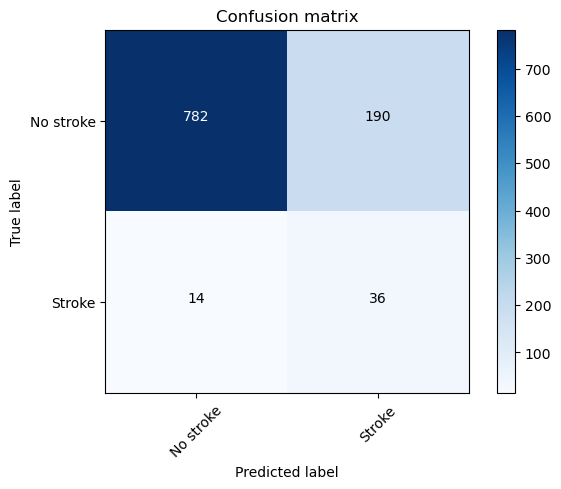

In [78]:
decision_tree_model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=45, min_samples_split=200, random_state=99)
decision_tree_model.fit(X_train, y_train)
y_pred = decision_tree_model.predict(X_test)

cm = utils.get_confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm=cm, classes=['No stroke', 'Stroke'])

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       972
           1       0.16      0.72      0.26        50

    accuracy                           0.80      1022
   macro avg       0.57      0.76      0.57      1022
weighted avg       0.94      0.80      0.85      1022



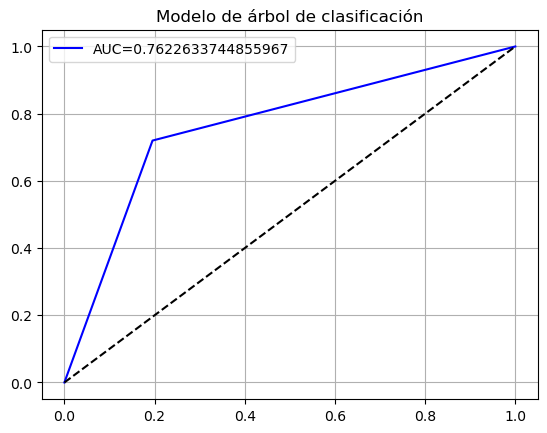

In [79]:
utils.print_metrics(y_test, y_pred, "Modelo de árbol de clasificación")

## Importancia de las variables

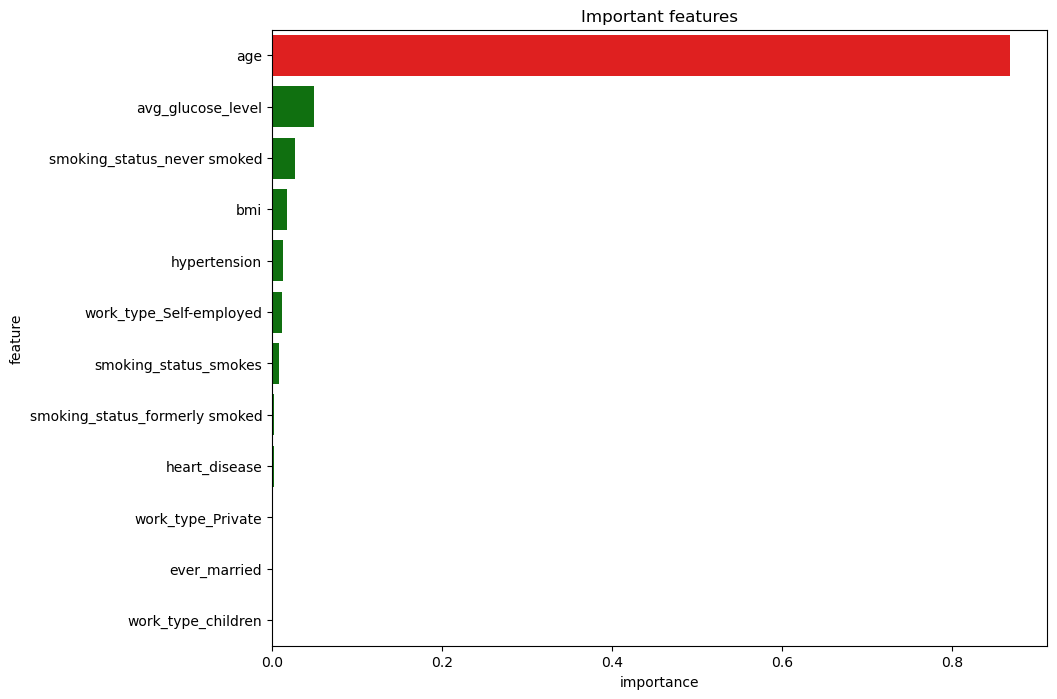

In [80]:
utils.plot_tree_feature_importance(decision_tree_model.feature_names_in_, decision_tree_model.feature_importances_)

## Árbol final

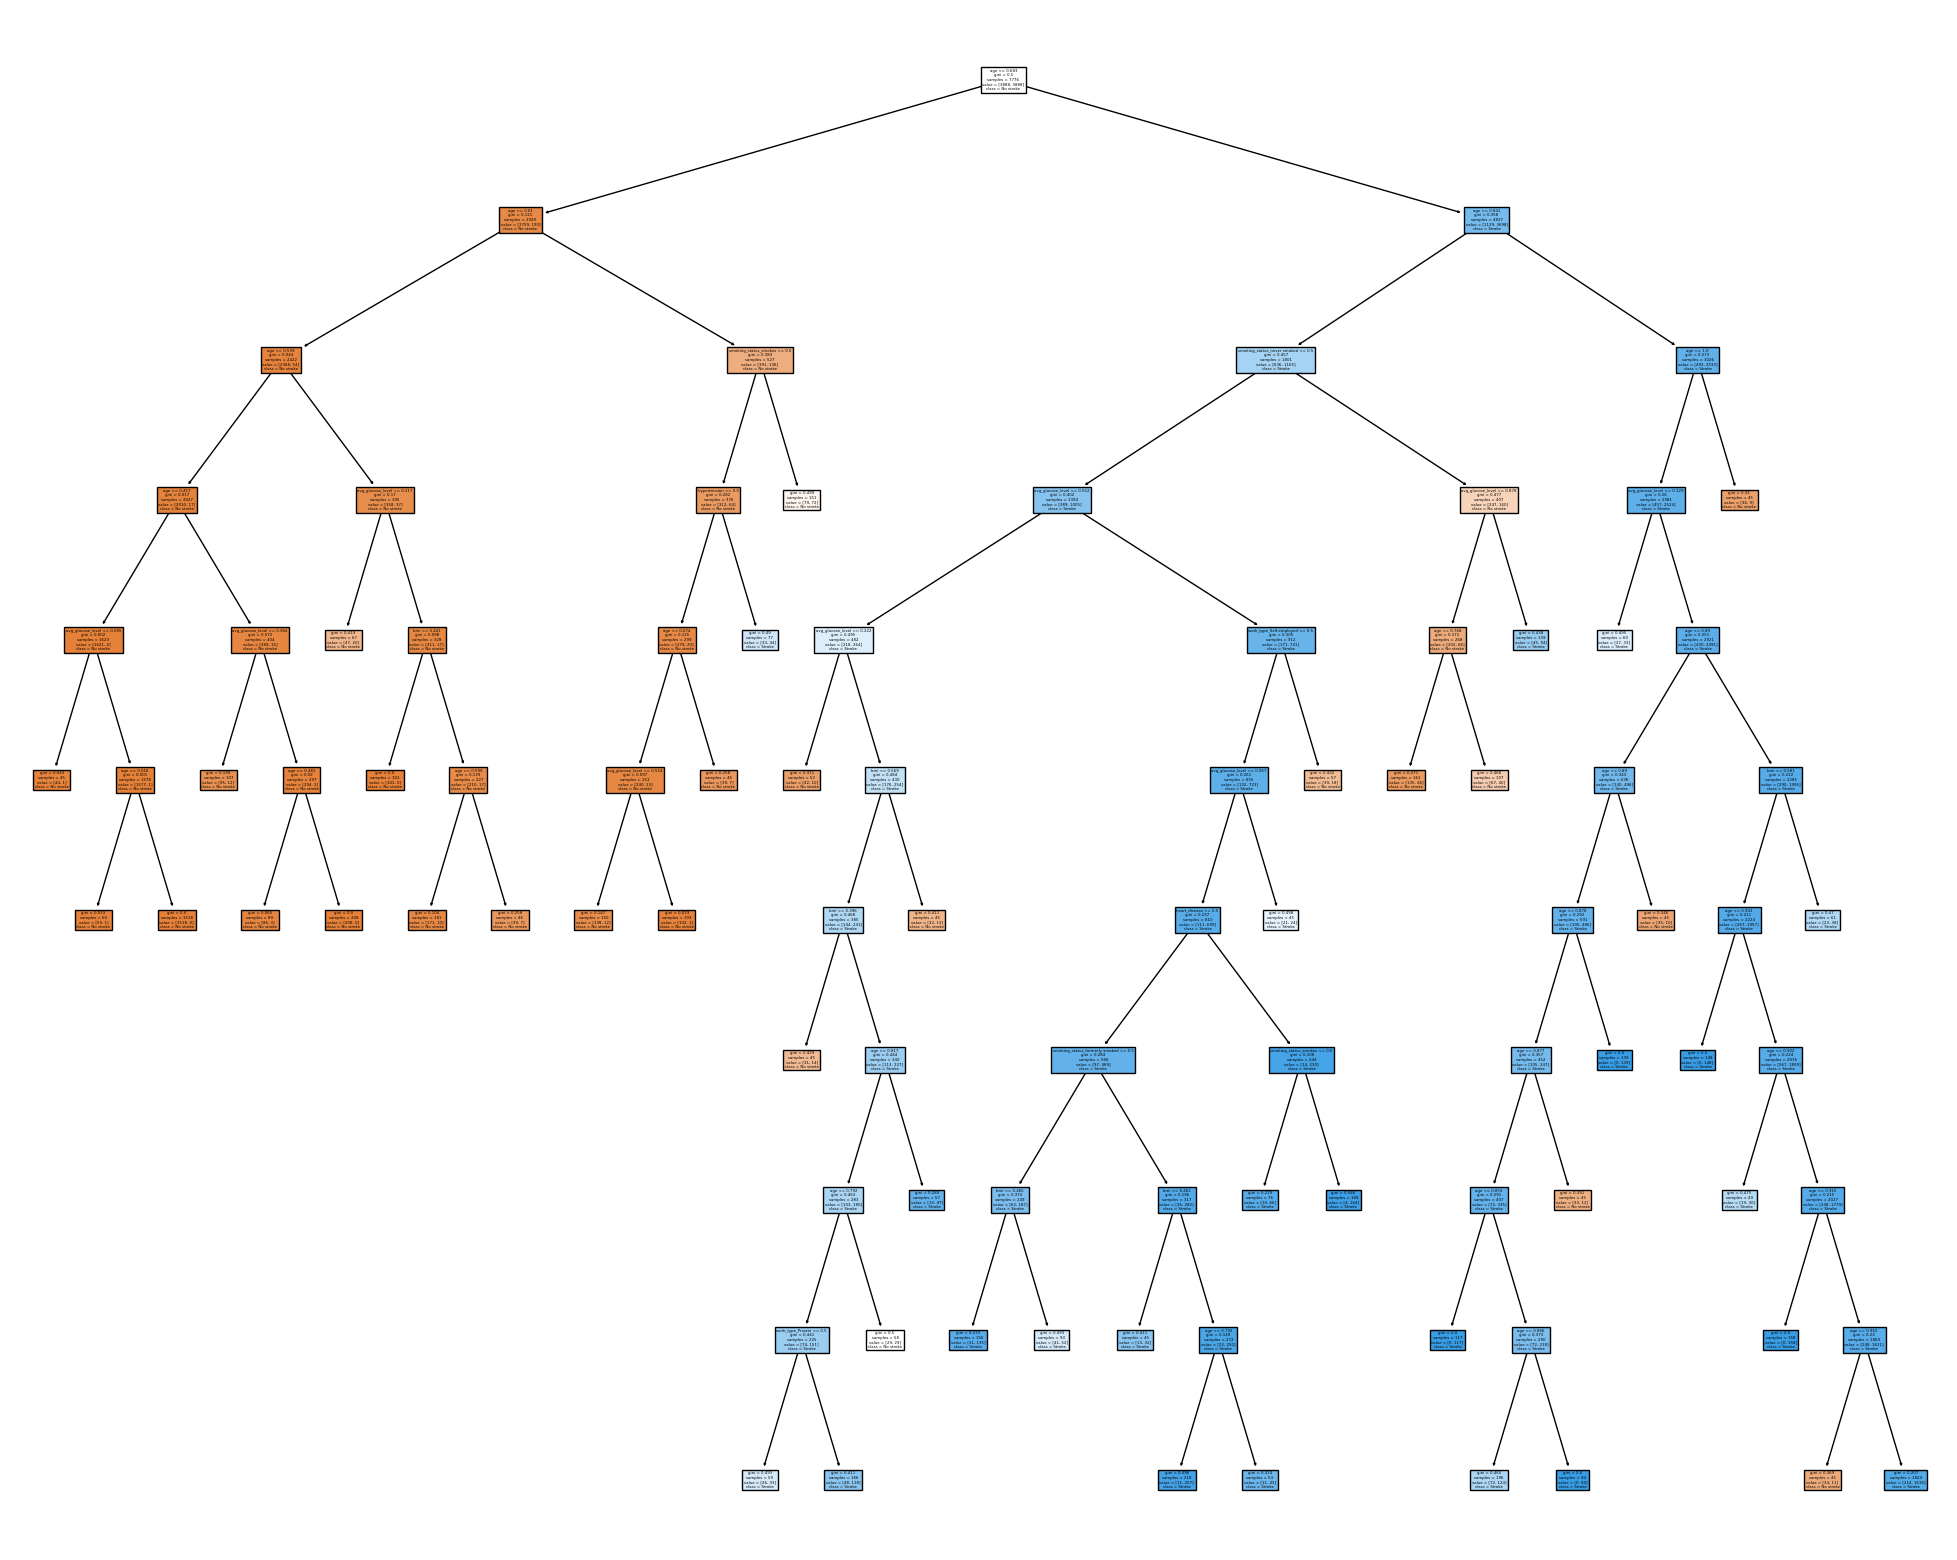

In [81]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_model, 
                   feature_names=decision_tree_model.feature_names_in_,  
                   class_names=['No stroke', 'Stroke'],
                   filled=True)

**Guardamos el modelo para la comparativa final**

In [82]:
pickle.dump(decision_tree_model, open("decision_tree_model.sav", 'wb'))